In [4]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt

monthly = pd.read_csv('datasets/refugee-data/asylum_seekers_monthly.csv', low_memory=False)
asylees = pd.read_csv('datasets/refugee-data/asylum_seekers.csv', low_memory=False)
demographics = pd.read_csv('datasets/refugee-data/demographics.csv', low_memory=False)

### [UNHCR Refugee Data](https://www.kaggle.com/unitednations/refugee-data)  
This dataset includes 6 csv files. I will be looking at only the following two: 
<ul>
    <li>Yearly progress through the refugee system (<code>asylum_seekers.csv</code>)</li>
    <li>Refugee demographics (<code>demographics.csv</code>)</li>
    </ul>
    
#### Questions that I looked into:
<ol>
    <li>What was the distribution of acceptance rates? Which countries (of origin) had higher acceptance rates? </li>
    <li>Which countries of resettlement accepted higher percentages of people? From which countries? </li>
    <li>Was there any statistical significance to the age of the applicants and the acceptance rate?</li>
</ol>

## Question 1 - a) What was the distribution of acceptance rates? b) Which countries (of origin) had higher acceptance rates?

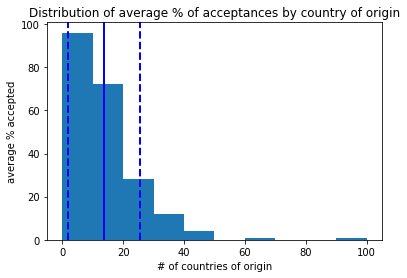

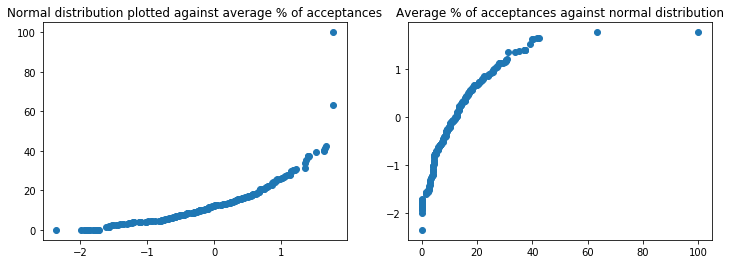

In [15]:
# 1a distrubtion of acceptance rates?

# the ints/floats in the table are stored as strings, need to convert...

colnames = asylees.columns.values
asylees[colnames[4:]] = asylees[colnames[4:]].apply(pd.to_numeric, errors='coerce', axis=1).fillna(0.0)

# add a column for % accepted and % rejected for 

# getting the % (faiz) recognized (accepted) for each row
asylees['faiz_accepted'] = ((asylees['decisions_recognized']) / (asylees['Total decisions'])*100)

# % (faiz) rejected
asylees['faiz_rejected'] = ((asylees['Rejected']) / (asylees['Total decisions'])*100)

# order by average % accepted
accepted = asylees.groupby('Origin')['faiz_accepted'].mean()

siusplau = accepted.sort_values()

plt.hist(siusplau[:-8])
# line at the mean
plt.axvline(siusplau[:-8].mean(), color='b', linestyle='solid', linewidth=2)

#line at 1 standard dev above mean
plt.axvline(siusplau[:-8].mean() + siusplau[:-8].std(), color='b', linestyle='dashed', linewidth=2)

#and 1 standard dev below the mean
plt.axvline(siusplau[:-8].mean() - siusplau[:-8].std(), color='b', linestyle='dashed', linewidth=2)

plt.title('Distribution of average % of acceptances by country of origin')
plt.xlabel('# of countries of origin')
plt.ylabel('average % accepted')
plt.show()

mean = 0 
sd = 1
n = 215

norm = np.random.normal(0, 1, 222)
norm.sort()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(norm, siusplau, "o") 
plt.title('Normal distribution plotted against average % of acceptances')

plt.subplot(1, 2, 2)
plt.plot(siusplau, norm, "o")
plt.title('Average % of acceptances against normal distribution')

plt.show() 

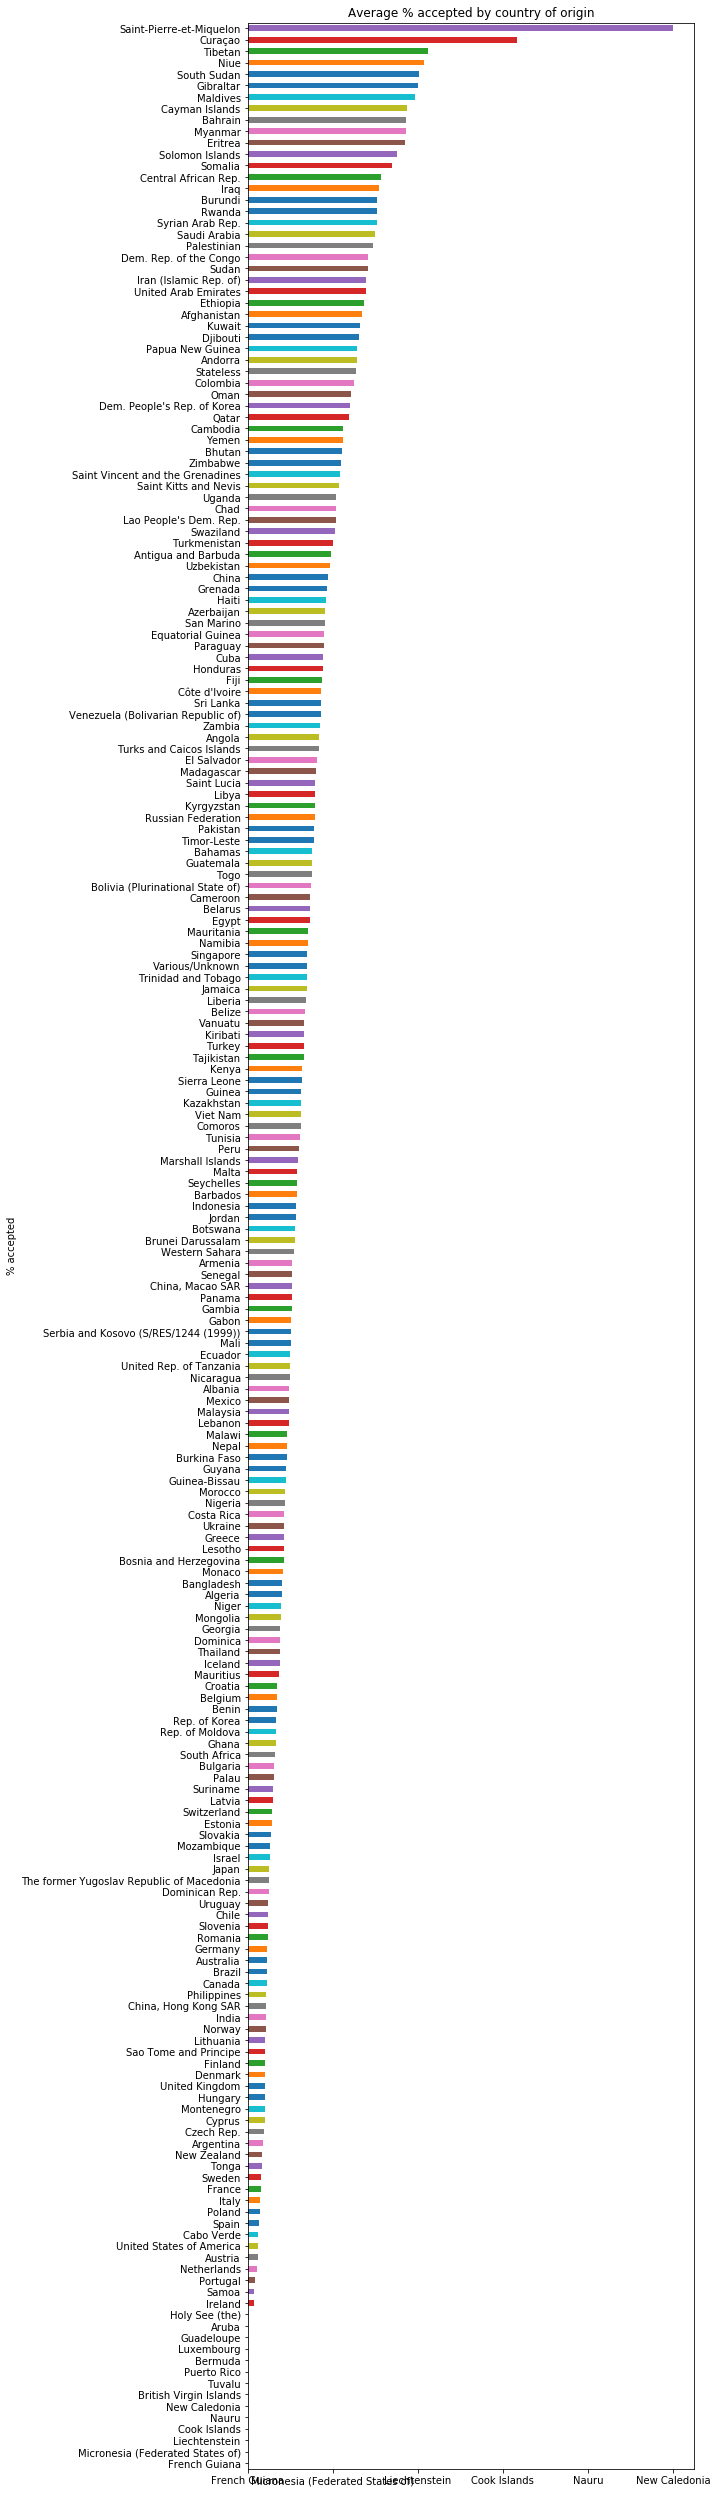

In [60]:
# 1b - which countries of origin had higher acceptance rates? 

plt.figure(figsize=(8,45))

ax = siusplau[:-8].plot(kind='barh')

ax.set_ylabel('% accepted')
ax.set_title('Average % accepted by country of origin')
ax.set_xticklabels(siusplau[:-8].index.values)

plt.show()

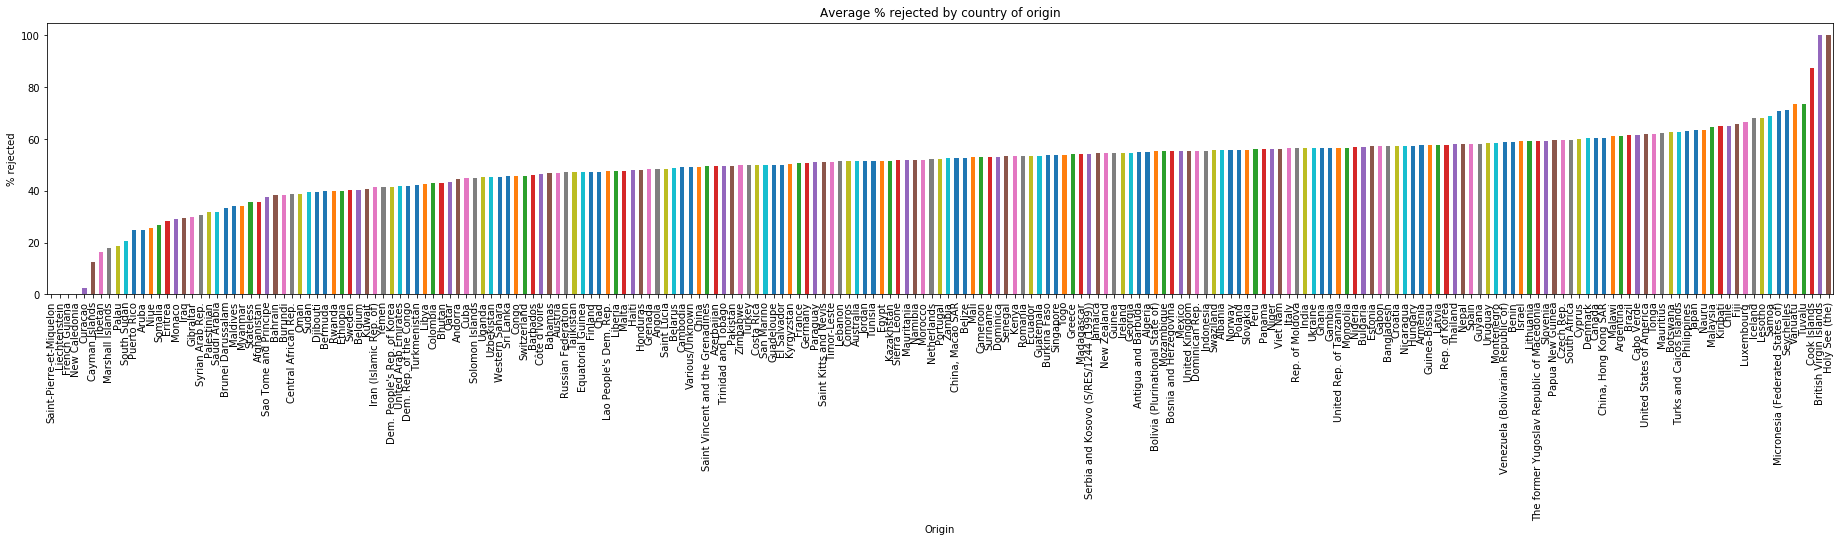

In [16]:
# also relevant to 1b, is which countries of origin had higher rejection rates?

rejected = asylees.groupby('Origin')['faiz_rejected'].mean()
rejected.var()

rejected.std(ddof=1)

mehhh = rejected.sort_values(ascending=True)

plt.figure(figsize=(32,5))

ax = mehhh[:-7].plot(kind='bar')

ax.set_ylabel('% rejected')
ax.set_title('Average % rejected by country of origin')
ax.set_xticklabels(mehhh[:-7].index.values)

plt.show()

## Question 2 - Which countries of resettlement accepted higher percentages of people? From which countries?

In [27]:
# getting a list of all of the countries of residence 

newlocs = asylees['Country / territory of asylum/residence'].tolist()

#to get rid of duplicates etc
all_newlocs = list(set(newlocs))

# create dataframe to put top 5 rejected / accepted by country of resettlement

#first get the col names
accepted5 = ['Resettled country']
rejected5 = []

to5 = np.arange(1,6)

for num in to5:
    accepted5.append('Top {} Accepted'.format(num))
    accepted5.append('Top {} Ac. percentage'.format(num))
    rejected5.append('Top {} Rejected'.format(num))
    rejected5.append('Top {} Re. percentage'.format(num))
    
colheader = accepted5+rejected5

rows_list = []
dict_list = [{}] * 190
i = 0

# now fill it up row by row
for loca in all_newlocs:

    # get a table of just refugees resettled in that country, no NaNs
    rstld = asylees[asylees['Country / territory of asylum/residence'] == loca].dropna(axis=0, how='any')   

    #get percentages for all of the countries in that smaller table
    accept_from_origin = rstld.groupby('Origin')['faiz_accepted'].mean()

    # top 5 most accepted % by country x
    top5 = accept_from_origin.sort_values(ascending=False).head(5)

    # create a list "row" to put the content
    row = [loca]
           
    # add top 5 most accepted
    for index, val in top5.iteritems():
        row.append(index)
        row.append(val)
    
    # top 5 most rejected % by country x, then add them

    reject_from_origin = rstld.groupby('Origin')['faiz_rejected'].mean()
    top5r = reject_from_origin.sort_values(ascending=False).head(5)

    for index, val in top5r.iteritems():
        row.append(index)
        row.append(val)
    
    # add to the dictionary 
    dict_list[i] = {}
    for header, content in zip(colheader,row):
        dict_list[i][header] = content

    i+=0
    # now adding the content for the country as a new row to the list of rows
    rows_list.append(dict_list[i])
    
    
# making the dataframe
alltop5s = pd.DataFrame(rows_list, columns=(colheader))  

#get rid of Nans
alltop5s.fillna(value=0.0, inplace=True)

# getting the average of top 5 accepted for each row
alltop5s['average of top 5 accepted %s'] = 0

# and lets do average of top 5 rejected at the same time
alltop5s['average of top 5 rejected %s'] = 0

for j in range(1,6):
    alltop5s['average of top 5 accepted %s'] += ((alltop5s['Top {} Ac. percentage'.format(j)]))
    alltop5s['average of top 5 rejected %s'] += ((alltop5s['Top {} Re. percentage'.format(j)]))

alltop5s['average of top 5 accepted %s'] = (alltop5s['average of top 5 accepted %s']/5)
alltop5s['average of top 5 rejected %s'] = (alltop5s['average of top 5 rejected %s']/5)

alltop5s['difference between top 5 A and R'] = (alltop5s['average of top 5 accepted %s'] - alltop5s['average of top 5 rejected %s'])

In [29]:
alltop5s.sort_values('difference between top 5 A and R', ascending=False, inplace=True)

alltop5s.head(5)

,Resettled country,Top 1 Accepted,Top 1 Ac. percentage,Top 2 Accepted,Top 2 Ac. percentage,Top 3 Accepted,Top 3 Ac. percentage,Top 4 Accepted,Top 4 Ac. percentage,Top 5 Accepted,...,Top 2 Re. percentage,Top 3 Rejected,Top 3 Re. percentage,Top 4 Rejected,Top 4 Re. percentage,Top 5 Rejected,Top 5 Re. percentage,average of top 5 accepted %s,average of top 5 rejected %s,difference between top 5 A and R
50,Nicaragua,Palestinian,100.0,Guatemala,100.0,Uganda,100.0,Central African Rep.,100.0,Dominican Rep.,...,0.0,Dominican Rep.,0.0,Haiti,0.0,Guatemala,0.0,100.000000,0.238095,99.761905
41,Gambia,Sudan,100.0,Nepal,100.0,Iraq,100.0,Guinea-Bissau,100.0,Eritrea,...,0.0,Somalia,0.0,Senegal,0.0,Rwanda,0.0,100.000000,2.521739,97.478261
84,Lesotho,Zimbabwe,100.0,Rwanda,100.0,Eritrea,100.0,Algeria,100.0,Ethiopia,...,0.0,Ethiopia,0.0,Eritrea,0.0,Dem. Rep. of the Congo,0.0,90.000000,0.000000,90.000000
26,Vanuatu,Iraq,100.0,Iran (Islamic Rep. of),100.0,Indonesia,100.0,Sri Lanka,50.0,Sri Lanka,...,0.0,Indonesia,0.0,0,0.0,0,0.0,80.000000,0.000000,80.000000
177,Madagascar,Yemen,100.0,Somalia,100.0,Central African Rep.,100.0,Afghanistan,100.0,Pakistan,...,0.0,Somalia,0.0,Pakistan,0.0,Central African Rep.,0.0,98.333333,20.000000,78.333333


## Question 3 - Was there any statistical significance of the age of the refugees to their acceptance rate?

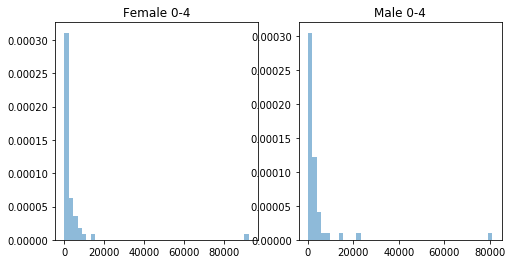

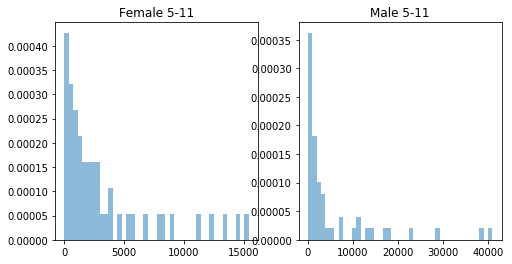

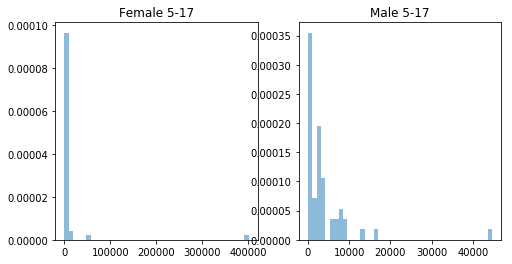

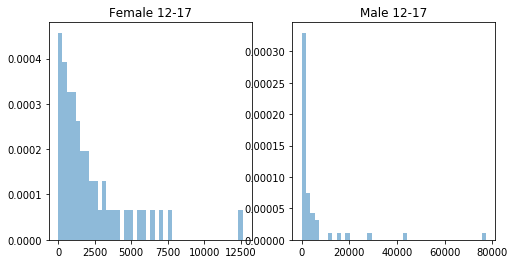

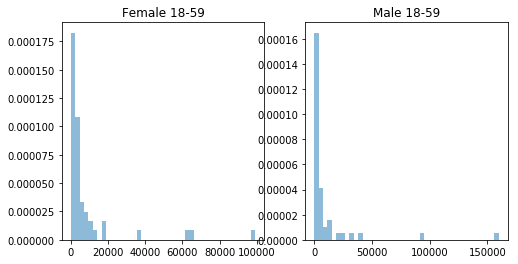

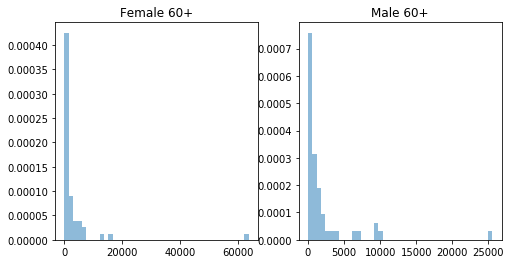

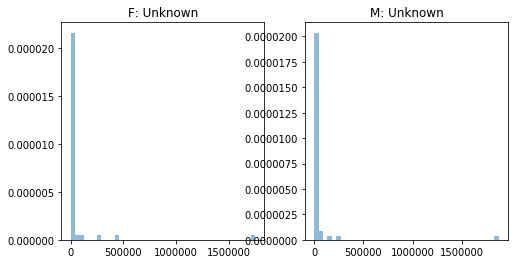

In [32]:
# cleaning up the dataframe a bit

# dropping the city because we are just going to be looking by country
la = demographics.drop(columns=['Location Name'])

# getting the column names so we can convert the ones that are necessary to numeric
from2 = la.columns.values

female = from2[2:9]
male = from2[10:]

for val in from2[2:]:
    la[val] = la[val].apply(pd.to_numeric, errors='coerce') 

la.fillna(value=0.0, inplace=True)
la.replace(to_replace='*', value=0.0)

# taking a look at distribution of ages of refugees just to get a general idea

for val, totals in zip(female,male):
    templist_f = []
    templist_f[:] = []
    templist_m = []
    templist_m[:] = []
    sample1 = []
    sample2 = []
      
    templist_f = list(filter(lambda v: v==v, list(set(la[val].tolist()))))
    
    templist_m = list(filter(lambda v: v==v, list(set(la[totals].tolist()))))
    
    x = len(templist_f)
    increment = int(x/50)
    i = 1
    while i < x:
        sample1.append(templist_f[i])
        i = i + increment
    
    y = len(templist_m)
    incrementy = int(y/50)
    i = 1
    while i < y:
        sample2.append(templist_m[i])
        i = i + incrementy
    
    plt.figure(figsize=(8,4))
    
    plt.subplot(1, 2, 1)
    plt.hist(sample1, normed=True, bins=42, alpha=.5) 

    plt.title('{}'.format(val))

    plt.subplot(1, 2, 2)
    plt.hist(sample2, normed=True, bins=42, alpha=.5) 
    plt.title('{}'.format(totals))
    
    plt.show()

In [36]:
# getting the data organized to compare the demographics with the yearly process / acceptance

# info of ages and genders by country and year
summed = la.groupby(['Country / territory of asylum/residence','Year']).sum() 

# info of acceptance rate by country and year
meaned = asylees.groupby(['Country / territory of asylum/residence','Year'])[ 'faiz_accepted', 'faiz_rejected'].mean()

# put into one dataframe

result = pd.concat([summed, meaned], axis=1, join='inner')

result.head(5)

Female 0-4  Female 5-11  \
Country / territory of asylum/residence Year                            
Afghanistan                             2001     14335.0          0.0   
                                        2002     24013.0          0.0   
                                        2003     92680.0          0.0   
                                        2004    127786.0          0.0   
                                        2005    105386.0          0.0   

                                              Female 5-17  Female 12-17  \
Country / territory of asylum/residence Year                              
Afghanistan                             2001      45452.0           0.0   
                                        2002      90337.0           0.0   
                                        2003     271223.0           0.0   
                                        2004     401884.0           0.0   
                                        2005     322375.0           0.0   

                                              Female 18-59  Female 60+  \
Country / territory of asylum/residence Year                             
Afghanistan                             2001       99882.0     19234.0   
                                        2002      227899.0     50424.0   
                                        2003      386000.0     63921.0   
                                        2004      564645.0     84486.0   
                                        2005      473751.0     54492.0   

                                              F: Unknown   F: Total  Male 0-4  \
Country / territory of asylum/residence Year                                    
Afghanistan                             2001    412004.0   590907.0   14716.0   
                                        2002   1563574.0  1956247.0   24196.0   
                                        2003    165788.0   979612.0  102322.0   
                                        2004   1679202.0  2858003.0  135341.0   
                                        2005   2155724.0  3111728.0  109064.0   

                                              Male 5-11  Male 5-17  \
Country / territory of asylum/residence Year                         
Afghanistan                             2001        0.0    47522.0   
                                        2002        0.0    95335.0   
                                        2003        0.0   297765.0   
                                        2004        0.0   434058.0   
                                        2005        0.0   348366.0   

                                              Male 12-17  Male 18-59  \
Country / territory of asylum/residence Year                           
Afghanistan                             2001         0.0    114968.0   
                                        2002         0.0    263719.0   
                                        2003         0.0    616159.0   
                                        2004         0.0    666423.0   
                                        2005         0.0    569200.0   

                                              Male 60+  M: Unknown   M: Total  \
Country / territory of asylum/residence Year                                    
Afghanistan                             2001   13025.0    435492.0   625723.0   
                                        2002   39678.0   1891309.0  2314237.0   
                                        2003   64568.0    209839.0  1290653.0   
                                        2004   79086.0   1871629.0  3186537.0   
                                        2005   51661.0   2237077.0  3315368.0   

                                              faiz_accepted  faiz_rejected  
Country / territory of asylum/residence Year                                
Afghanistan                             2001      13.030303      69.494949  
                                        2002       0.000000     100.000000  
                                        2003     

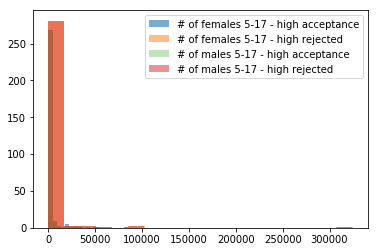

In [66]:
# get the distribution of lets say # of female 5-17 who were in a year with > 60% acceptance
# and then the distribution of # of female 5-17 < 60% acceptance
# and compare with t test etc

high_accept = result[result['faiz_accepted'] >=60 ]
high_reject = result[result['faiz_rejected'] >=60 ]

x = 19

plt.hist(high_accept['Female 5-17'].sort_values(ascending=True), alpha=0.6, bins=x, 
         stacked=False,  label='# of females 5-17 - high acceptance') 
plt.hist(high_reject['Female 5-17'].sort_values(ascending=True), alpha=0.5, bins=x, 
         stacked=False, label='# of females 5-17 - high rejected') 
plt.hist(high_accept['Male 5-17'].sort_values(ascending=True), alpha=0.3, bins=x, 
         stacked=False,  label='# of males 5-17 - high acceptance') 
plt.hist(high_reject['Male 5-17'].sort_values(ascending=True), alpha=0.5, bins=x, 
         stacked=False, label='# of males 5-17 - high rejected') 
plt.legend(loc='upper right') 
plt.show()

In [38]:
list1a = high_accept['Female 5-17'].tolist()
list2a = high_accept['Male 5-17'].tolist()
list3a = list1a+list2a
list3a.sort()

list1b = high_reject['Female 5-17'].tolist()
list2b = high_reject['Male 5-17'].tolist()
list3b = list1b+list2b
list3b.sort()

high_FM517 = np.array(list3a)
low_FM517 =  np.array(list3b)

# mean and std of each
print('Mean amt of youth ages 5-17 in highly ACCEPTED groups: {}'.format(high_FM517.mean()))
print('Mean amt of youth ages 5-17 in highly REJECTED groups: {}'.format(low_FM517.mean()))
print('Std dev for youth ages 5-17 in highly ACCEPTED groups: {}'.format(high_FM517.std()))
print('Std dev for youth ages 5-17 in highly REJECTED groups: {}'.format(low_FM517.std()))

# difference between the two means
diff=high_FM517.mean( ) -low_FM517.mean()
print('Difference between two means: {}'.format(diff))

Mean amt of youth ages 5-17 in highly ACCEPTED groups: 1943.8174061433447
Mean amt of youth ages 5-17 in highly REJECTED groups: 2992.405172413793
Std dev for youth ages 5-17 in highly ACCEPTED groups: 7900.3220569276955
Std dev for youth ages 5-17 in highly REJECTED groups: 21203.555628949907
Difference between two means: -1048.5877662704484


In [39]:
# getting the std error of sampling distribution
size = np.array([len(high_FM517), len(low_FM517)])
sd = np.array([high_FM517.std(), low_FM517.std()])

# The squared standard deviations are divided by the sample size and summed, then we take
# the square root of the sum. 
diff_se = (sum(sd ** 2 / size)) ** 0.5  

# T-value (difference between the means divided by the standard error)
print(diff/diff_se) 

# since this isn't a normal distribution, Mann Whitney test is necessary...

scipy.stats.mannwhitneyu(high_FM517, low_FM517, use_continuity=True, alternative=None)

-1.1167411518


MannwhitneyuResult(statistic=167885.0, pvalue=0.32171654802158756)

In [40]:
# null hypothesis is that there is no difference between the populations. 
# the null hypothesis is rejected when p < .05 and not rejected when p > .05. 

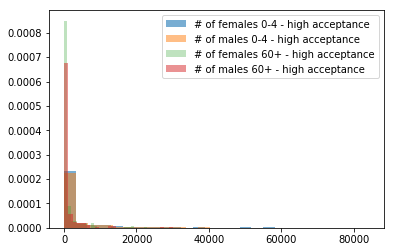

In [41]:
# i just checked for the same population - now i'll check for differences between
# different populations

x = 25

plt.hist(high_accept['Female 0-4'].sort_values(ascending=True), alpha=0.6, bins=x, normed=True, 
         label='# of females 0-4 - high acceptance') 
plt.hist(high_accept['Male 0-4'].sort_values(ascending=True), alpha=0.5, bins=x, normed=True, 
         label='# of males 0-4 - high acceptance') 
plt.hist(high_accept['Female 60+'].sort_values(ascending=True), alpha=0.3, bins=x, normed=True, 
         label='# of females 60+ - high acceptance') 
plt.hist(high_accept['Male 60+'].sort_values(ascending=True), alpha=0.5, bins=x, normed=True, 
         label='# of males 60+ - high acceptance') 
plt.legend(loc='upper right') 
plt.show()


In [42]:
list_1a = high_accept['Female 0-4'].tolist()
list_2a = high_accept['Male 0-4'].tolist()
list_3a = list_1a+list_2a
list_3a.sort()

list_1b = high_reject['Female 60+'].tolist()
list_2b = high_reject['Male 60+'].tolist()
list_3b = list_1b+list_2b
list_3b.sort()

high_FM04 = np.array(list_3a)
high_FM60 =  np.array(list_3b)

# mean and std of each
print('Mean amt of children 0-4 in highly ACCEPTED groups: {}'.format(high_FM04.mean()))
print('Mean amt of elders aged 60+ in highly ACCEPTED groups: {}'.format(high_FM60.mean()))
print('Std dev for children 0-4 in highly ACCEPTED groups: {}'.format(high_FM04.std()))
print('Std dev for elders aged 60+ in highly ACCEPTED groups: {}'.format(high_FM60.std()))

# difference between the two means
diff=high_FM04.mean( ) - high_FM60.mean()
print('Difference between two means: {}'.format(diff))

Mean amt of children 0-4 in highly ACCEPTED groups: 4616.090443686006
Mean amt of elders aged 60+ in highly ACCEPTED groups: 949.6396551724138
Std dev for children 0-4 in highly ACCEPTED groups: 11138.946026620746
Std dev for elders aged 60+ in highly ACCEPTED groups: 4190.3872909001875
Difference between two means: 3666.4507885135927


In [44]:
# getting the std error of sampling distribution
size = np.array([len(high_FM04), len(high_FM60)])
sd = np.array([high_FM04.std(), high_FM60.std()])

# The squared standard deviations are divided by the sample size and summed, then we take
# the square root of the sum. 
diff_se = (sum(sd ** 2 / size)) ** 0.5  

# T-value (difference between the means divided by the standard error)
print(diff/diff_se)

# again, Mann Whitney test due to it being a non normal distribution
scipy.stats.mannwhitneyu(high_FM04, high_FM60,use_continuity=True, alternative=None)

7.45298674317


MannwhitneyuResult(statistic=113846.0, pvalue=4.2231532182984115e-23)